In [4]:
pip install neo4j -q

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install graphdatascience -q

In [92]:
import random
from neo4j import GraphDatabase
from graphdatascience import GraphDataScience
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
import networkx 
import pandas as pd
import matplotlib.pyplot as plt

In [83]:
host = "bolt://host:7687"
user = ""
password = ""

gds = GraphDataScience(host, auth=(user, password))

In [117]:
Fam, results = gds.graph.project("Famm", "Family", 
                                   {"NEIGHBOR": {"orientation": "UNDIRECTED"},
                                    "IS_SIMILAR": {"orientation": "UNDIRECTED"}
                                    })

In [112]:
gds.louvain.write(Fam, writeProperty = "louvainCommunity")

Louvain:   0%|          | 0/100 [00:00<?, ?%/s]

writeMillis                                                            828
nodePropertiesWritten                                                90872
modularity                                                        0.941388
modularities             [0.6689057085223302, 0.861720049912901, 0.9265...
ranLevels                                                                5
communityCount                                                         639
communityDistribution    {'p99': 1814, 'min': 1, 'max': 2783, 'mean': 1...
postProcessingMillis                                                    14
preProcessingMillis                                                      0
computeMillis                                                         7209
configuration            {'maxIterations': 10, 'writeConcurrency': 4, '...
Name: 0, dtype: object

In [131]:
gds.labelPropagation.write(Fam, writeProperty = "labelPropCommunity")

LabelPropagation:   0%|          | 0/100 [00:00<?, ?%/s]

writeMillis                                                            202
nodePropertiesWritten                                                90872
ranIterations                                                           10
didConverge                                                          False
communityCount                                                       18063
communityDistribution    {'p99': 27, 'min': 1, 'max': 1492, 'mean': 5.0...
postProcessingMillis                                                    29
preProcessingMillis                                                      0
computeMillis                                                          777
configuration            {'jobId': '9acc2b4f-efb9-4e0c-a67a-17caf8b75d1...
Name: 0, dtype: object

In [118]:
louvain_df = gds.run_cypher("""
CALL gds.louvain.stream('Famm')
YIELD nodeId, communityId
RETURN count(gds.util.asNode(nodeId).name) as family, communityId
ORDER BY family desc""")
label_df = gds.run_cypher("""
CALL gds.labelPropagation.stream('Famm')
YIELD nodeId, communityId
RETURN count(gds.util.asNode(nodeId).name) as family, communityId
ORDER BY family desc""")

In [141]:
gds.wcc.stats(Fam)['componentDistribution']

{'p99': 48,
 'min': 1,
 'max': 89512,
 'mean': 199.71868131868132,
 'p90': 5,
 'p50': 1,
 'p999': 89512,
 'p95': 11,
 'p75': 2}

In [140]:
pip install ipython-cypher -q

Note: you may need to restart the kernel to use updated packages.


In [119]:
louvain_df = louvain_df.sort_values(by='family', ascending=False)
label_df = label_df.sort_values(by='family', ascending=False)

In [123]:
len(louvain_df), len(label_df)

(633, 18061)

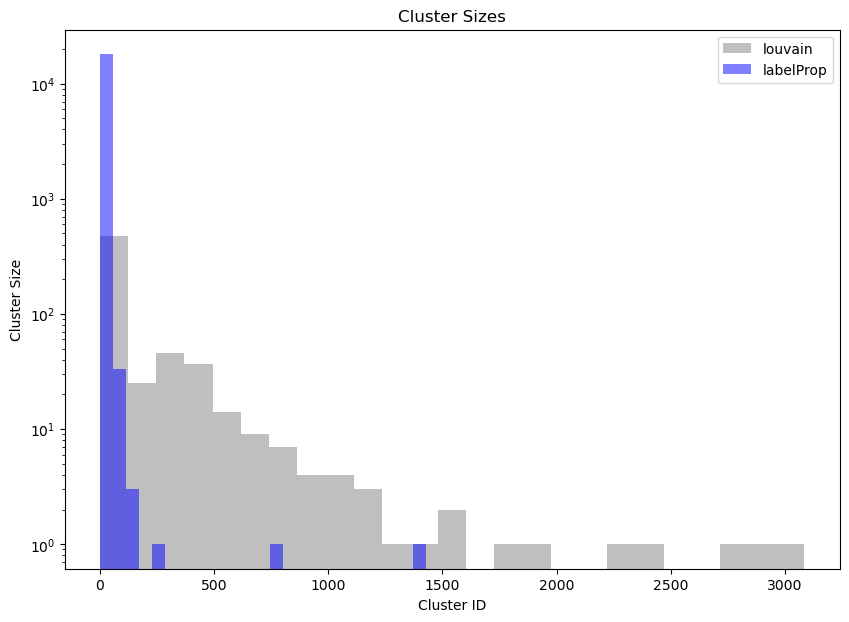

In [143]:
fig, ax = plt.subplots(figsize=(10, 7))

#plt.plot(label_df['family'], label_df['communityId'], label = "label")
ax.hist(louvain_df['family'], label = "louvain", bins=25, color='grey', alpha = 0.5)
ax.hist(label_df['family'], label = "labelProp", bins=25, color='blue', alpha=0.5)

# Add labels and title
plt.xlabel('Cluster ID')
plt.ylabel('Cluster Size')
plt.title('Cluster Sizes')

plt.yscale('log')

plt.legend()

# Display the plot
plt.show()

In [54]:
kmeans = KMeans(n_clusters=10)

In [52]:
embedding_df = gds.fastRP.stream(Fam, embeddingDimension=32)

In [142]:
kmeans_clusters = kmeans.fit_transform(list(embedding_df['embedding']))

In [ ]:
embedding_df['cluster'] = kmeans.labels_

In [ ]:
embedding_df['cluster'].value_counts()

In [ ]:
silhouette_score(list(embedding_df['embedding']), embedding_df['cluster'])

In [ ]:
kmeans_dict = embedding_df[['nodeId', 'cluster']].to_dict("records")

In [ ]:
gds.run_cypher("""
UNWIND $kmeansAssigments as row
MATCH (n) where id(n) = row['nodeId']
SET n.kMeansCommunity = row['cluster']
""", {"kmeansAssigments": kmeans_dict})